# CLASSIFICATION OF LAB SAMPLES

This notebook analyzes the accuracy of the SVM classifier on the training data and on lab samples.
The analysis makes use of data built by ClassificationData in the tools directory.
This class augments the global namespace to include data used in analysis.

The training data are:
* all genes (not just regulators);
* averaged;
* do not include T1 (since only one observtion)

# TO DO
1. Cross check with Mario about data characteristics
1. **Check calculation of pooled, whether average log**
1. Structure codes for the analyses conducted. This structure should be reflected in ``DATA_DCT``.
   1. Selection of genes: myco, myco +, all genes
   1. How counts are processed
      1. Reference - T0/biostat, T0/data source, pooled/data source
1. Evaluation of classifiers
   1. Performance on biostat data
   1. Performance on other samples
      1. Time consistency
      1. Replication consistency
      1. Consistency with expectation
1. Analyses for Eliza:
   1. Accuracy with all 11 and the accuracy as you add in more genes (same as what you just sent but with all 11).
   1. Could you test with just the 10 mycobactin genes (Rv2377c-Rv2386c)?
   1. Could you test with just bacterioferritin (Rv3841)? Just Rv2384?
   1. Is there one gene that gives good accuracy
1. compare accuracy with ranom selection of genes
1. Classifier coefficient profile.
   1. Eliza genes - 1-10
   1. Auto selected genes: 5, 10, 20

# Preliminaries

## Imports

In [1]:
import init
from common import constants as cn
from common_python.util import dataframe
from tools import make_classification_data

import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline

In [2]:
data = make_classification_data.ClassificationData()
data.get(globals())

## Constants

In [3]:
FULL_RUN = True

## Helper Functions

OK!


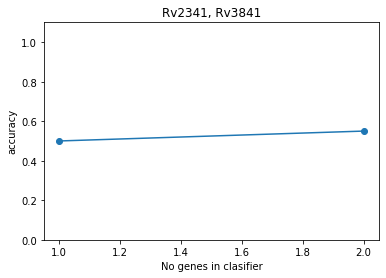

In [4]:
def plotAccuracy(genes, title="", selected_stages=None, size=100, is_plot=True, ax=None):
    """
    Plots the accuracy curve for a collection of genes
    
    Parameters
    ----------
    genes: list-str
    title: str
    selected_stages: list-str
        Create a binary classifier for just these tages
    size: int
    is_plot: bol
    """
    if ax is None:
        _, ax = plt.subplots(1)
    accuracy_dct = {}
    #data = mkDataSubset(genes, selected_stages=selected_stages)
    data = DATA_DCT[T0].subsetToStates(selected_stages, genes=genes)
    ranks = range(1, len(genes) + 1)
    for rank in ranks:
        accuracy_dct[rank] = CLASSIFIER.crossValidate(
            data, num_iter=10, num_holdout=1, filter_high_rank=rank, size=size)
    ax.plot(list(accuracy_dct.keys()), list(accuracy_dct.values()), marker="o")
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier")
    _ = ax.set_ylabel("accuracy")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return accuracy_dct
    
# Tests
genes = GENE_DCT["bacterioferritin"]
accuracy_dct = plotAccuracy(GENE_DCT["bacterioferritin"], title=", ".join(genes), selected_stages="StageII", size=5, is_plot=True)
assert(np.isclose(list(accuracy_dct.values())[0], 0.5))
print("OK!")

# Regulons for Divalent Metals

Note that Mnt (Rv2788) is constant in the Bioreactor data.

In [5]:
all_genes = TRINARY.df_X.columns
[g for g in all_genes if ("Rv2788" in g) or ("Rv2359" in g)]

['Rv0064--Rv1285--Rv2359--Rv2483c--Rv2484c--Rv2495c--Rv2500c--Rv2781c--Rv3334--Rv3536c']

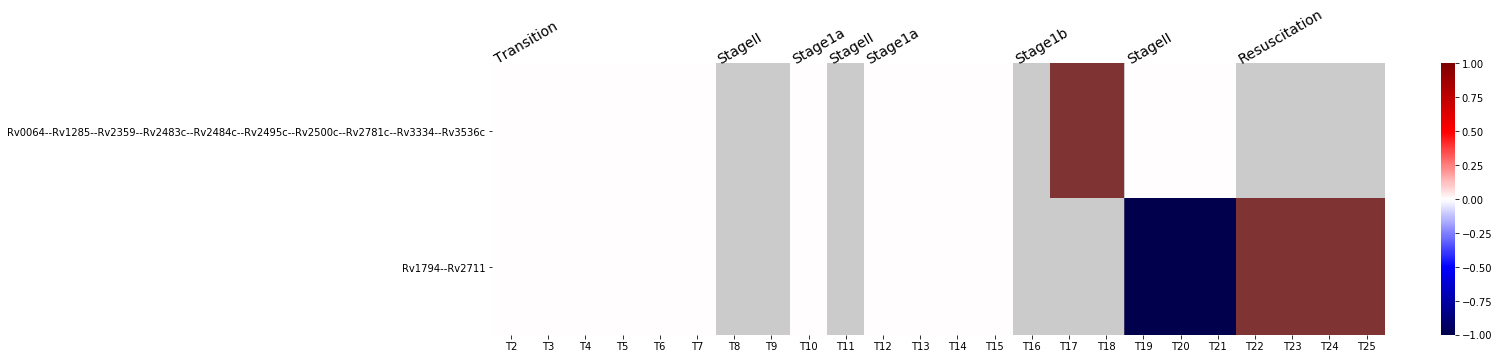

In [6]:
genes = ["Rv1794--Rv2711", "Rv0064--Rv1285--Rv2359--Rv2483c--Rv2484c--Rv2495c--Rv2500c--Rv2781c--Rv3334--Rv3536c"]
TRINARY.plotExpressionLevels(genes)

**Observations**
1. IdeR is involved only in later stages

# Gene Expression

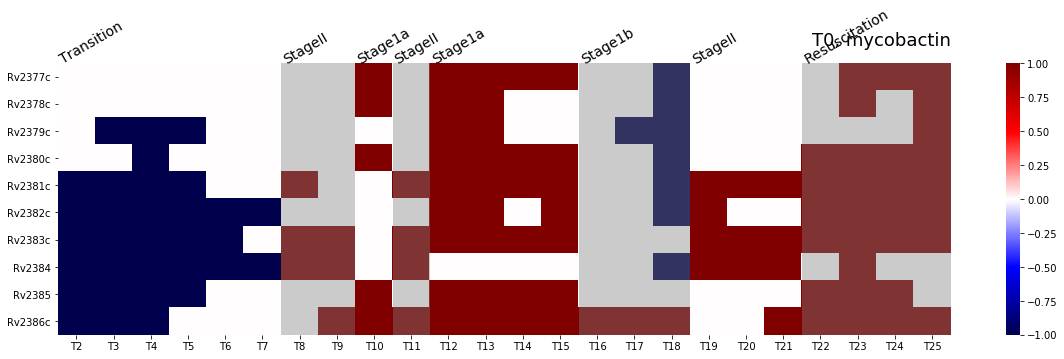

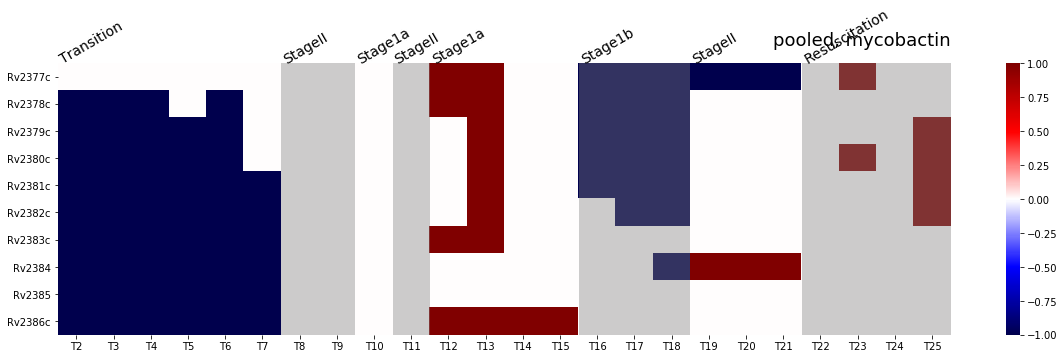

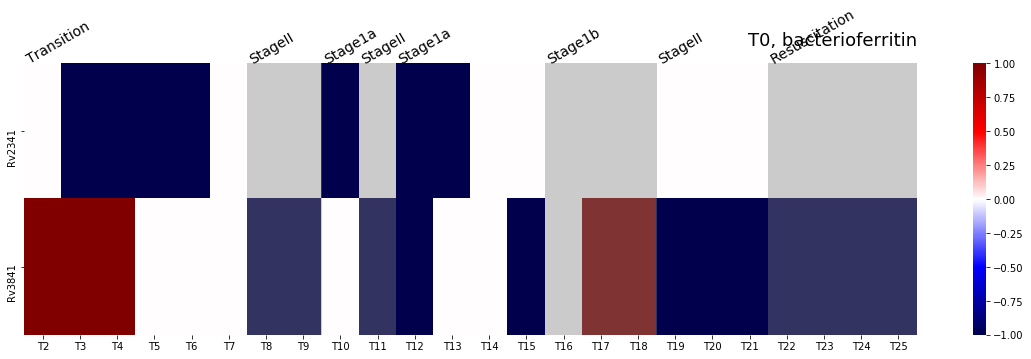

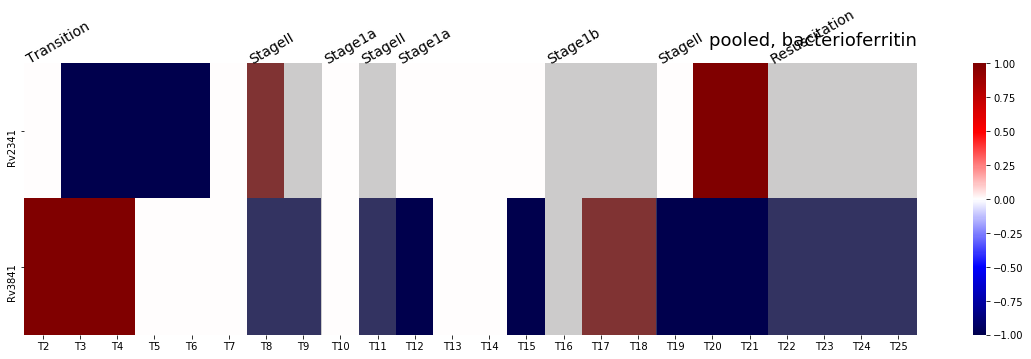

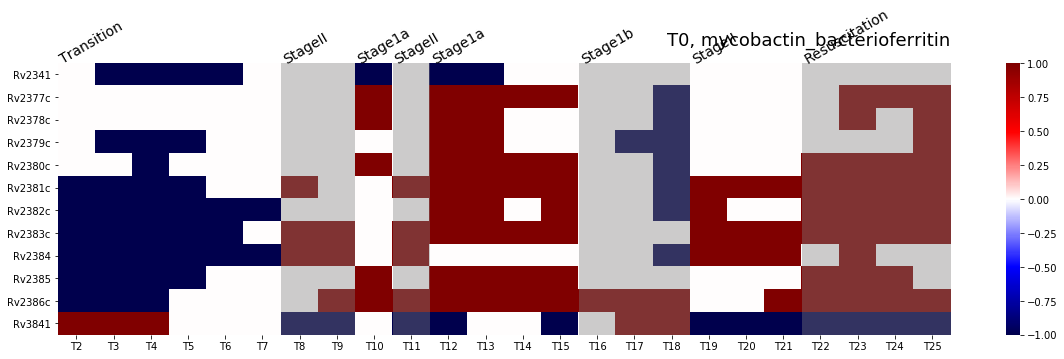

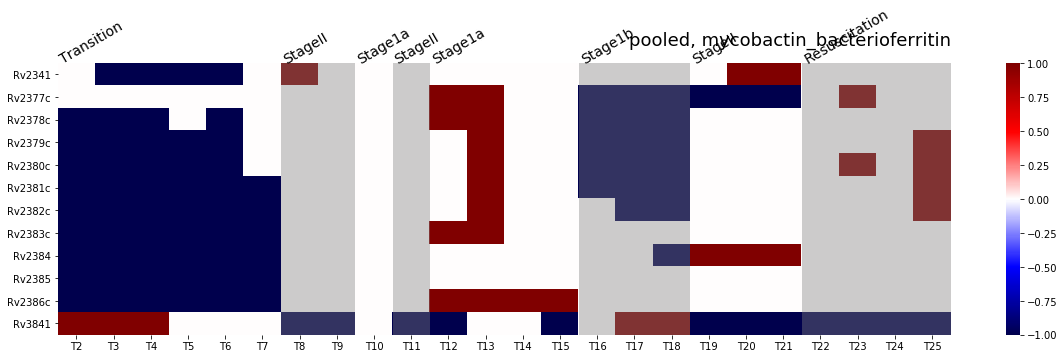

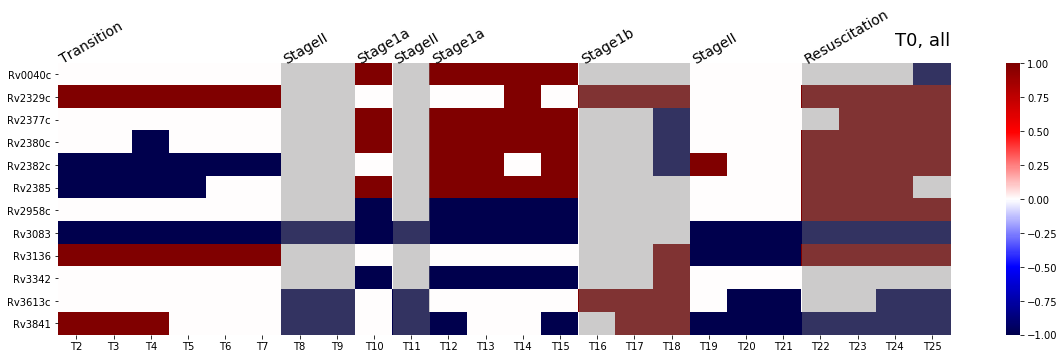

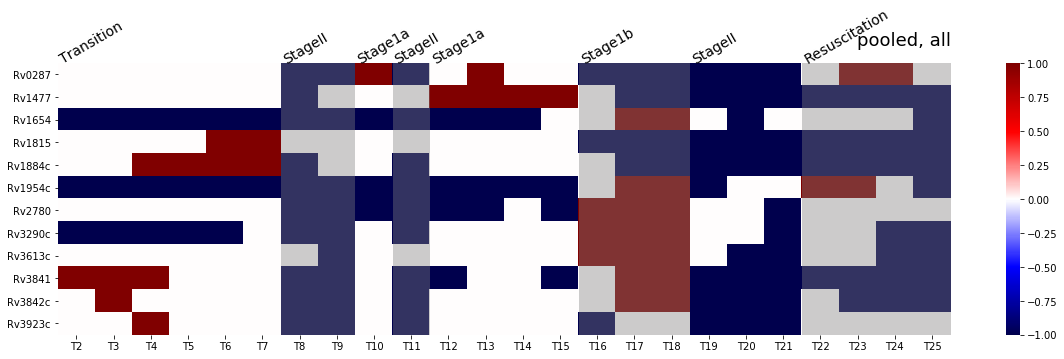

In [7]:
for group in GENE_DCT.keys():
    for ref, trinary in DATA_DCT.items():
        title = "%s, %s" % (ref, group)
        clf = CLASSIFIER_DCT[(ref, group)]
        genes = clf.features
        trinary.plotExpressionLevels(genes, title=title)

# Accuracy of Choices for Reference Data and Gene Groups

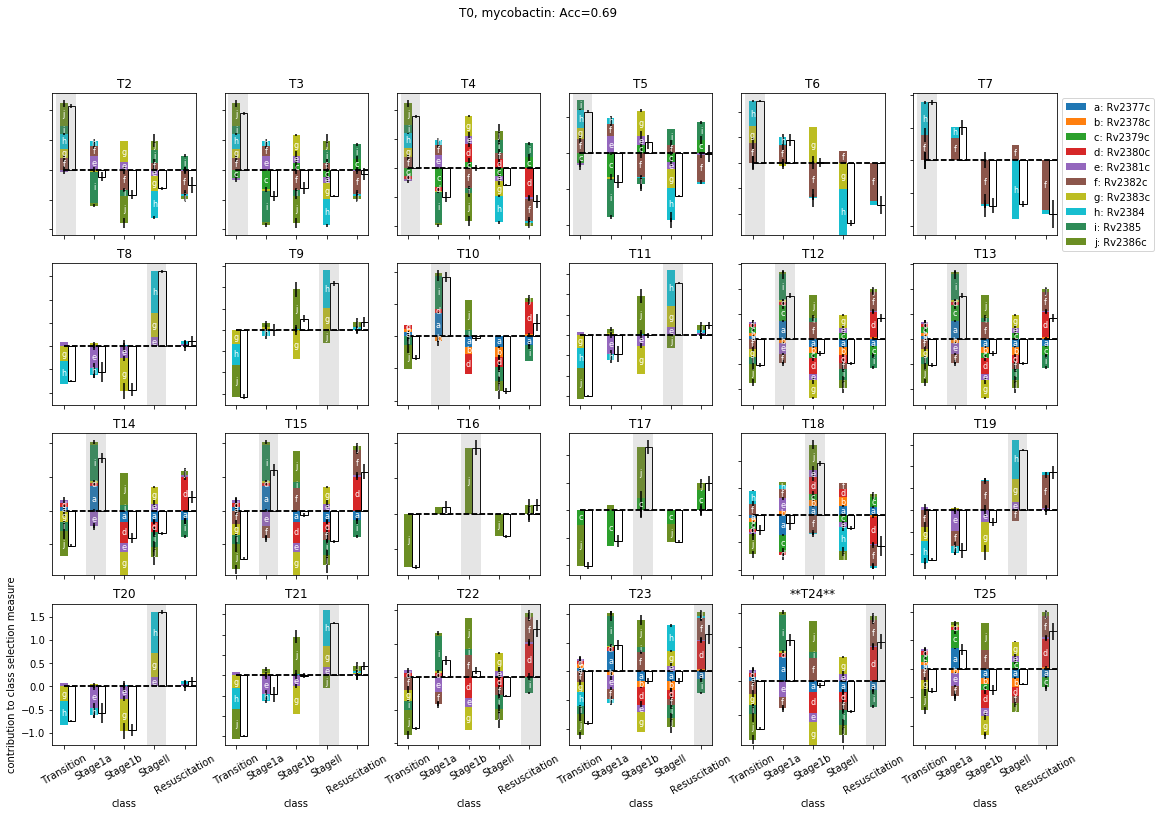

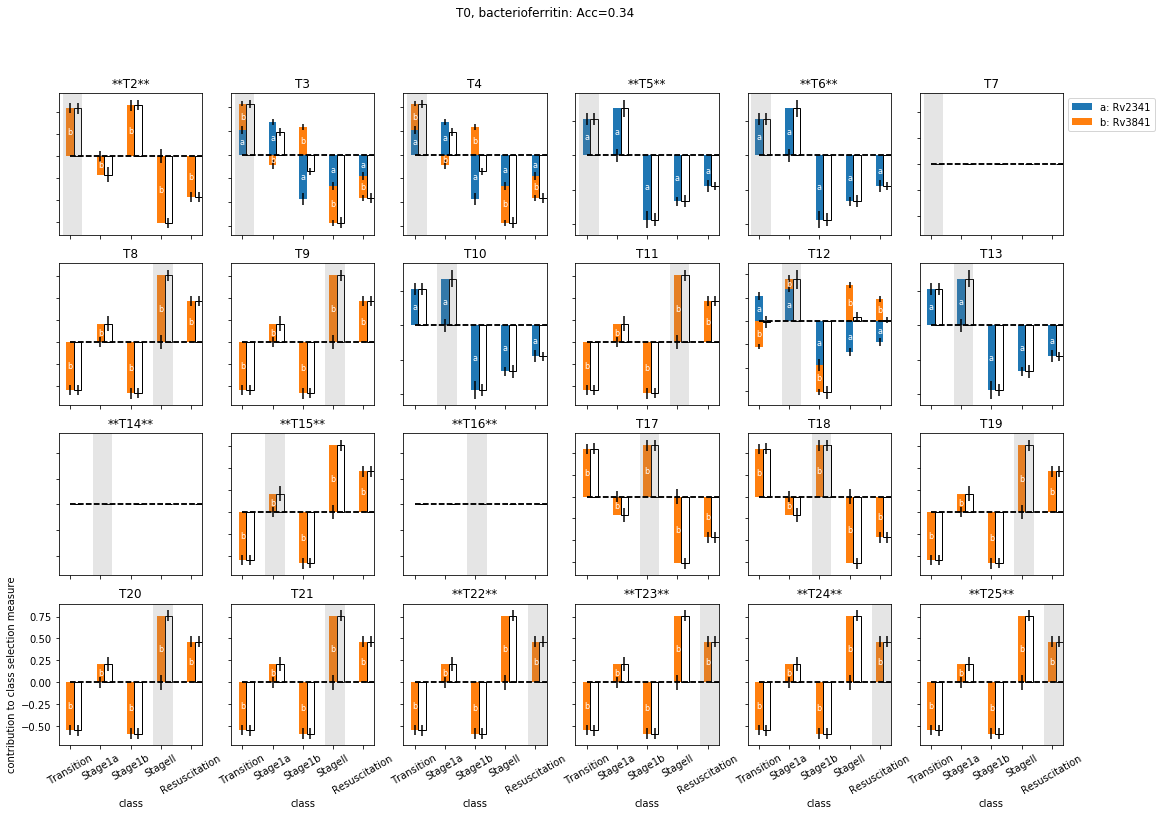

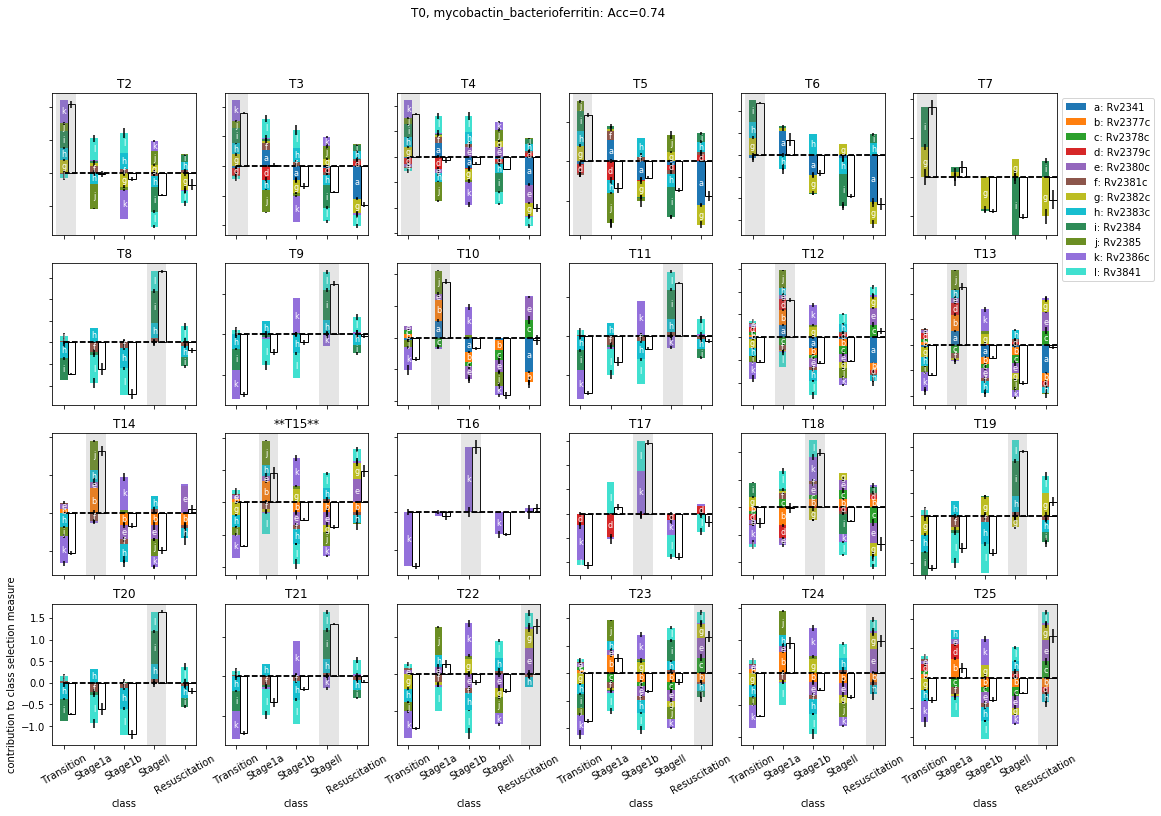

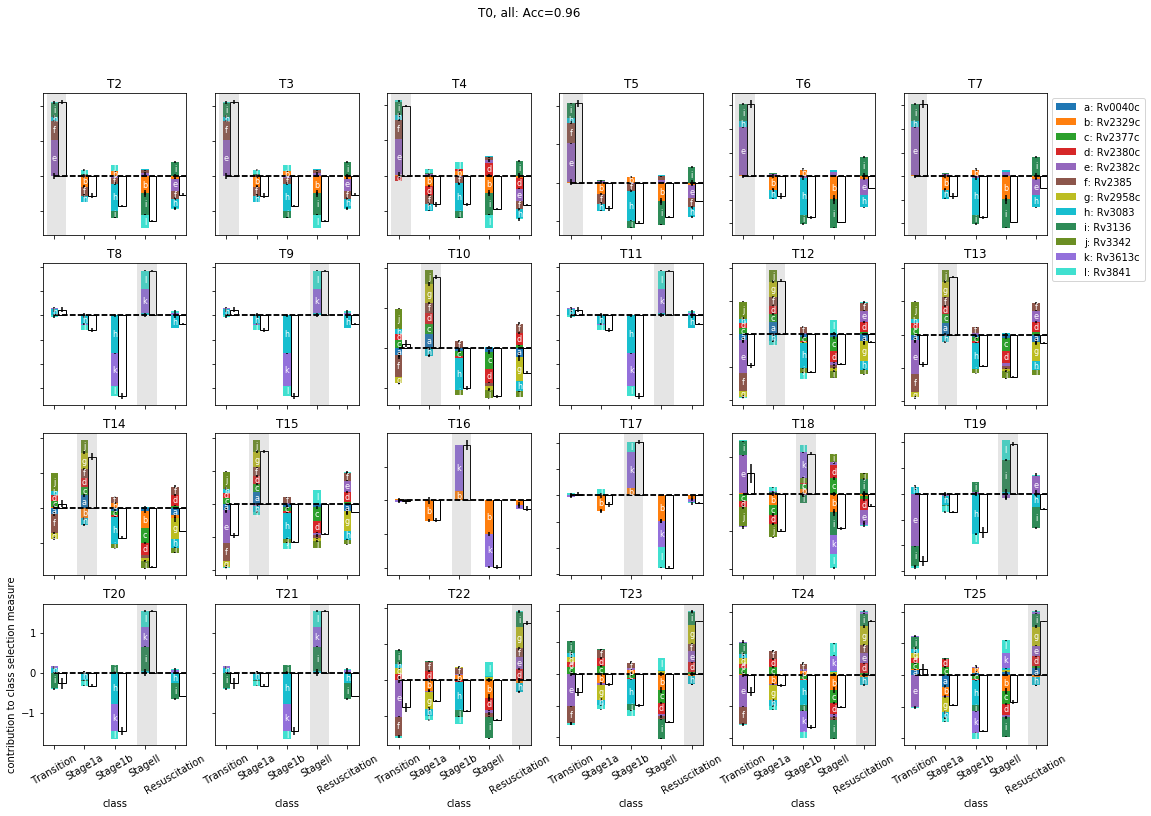

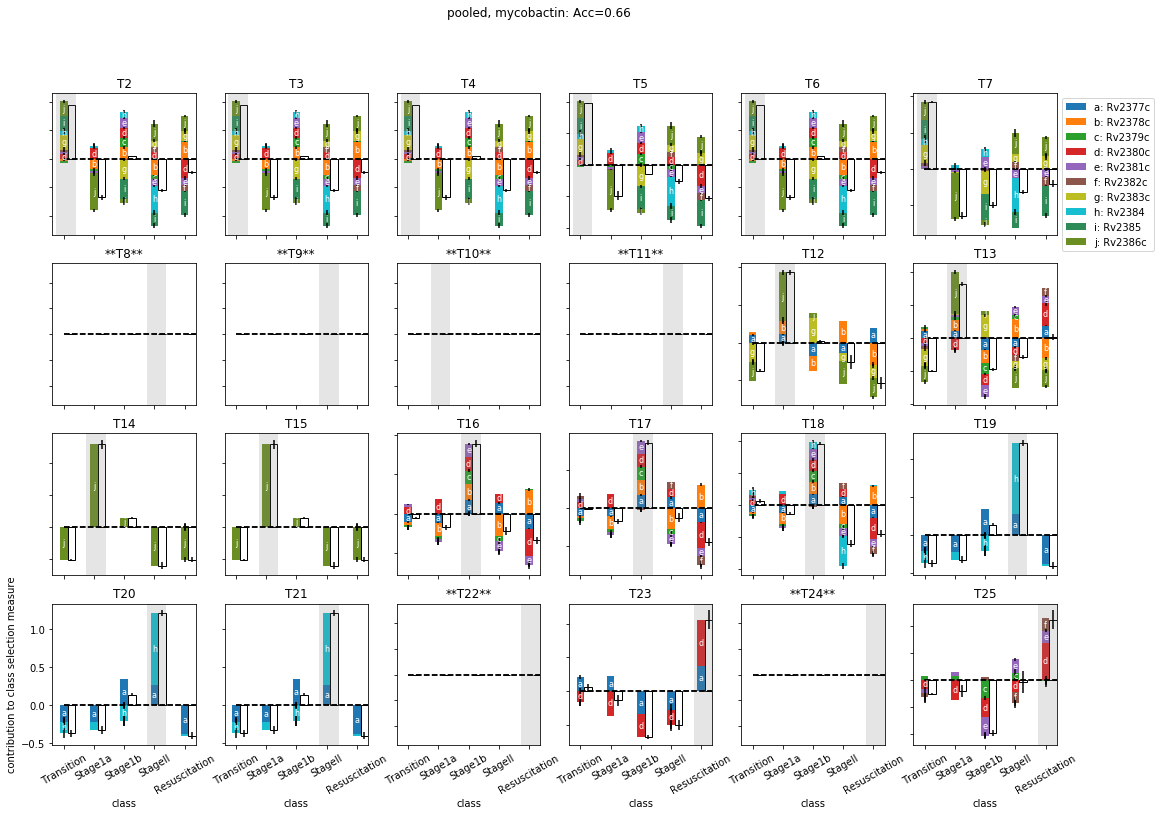

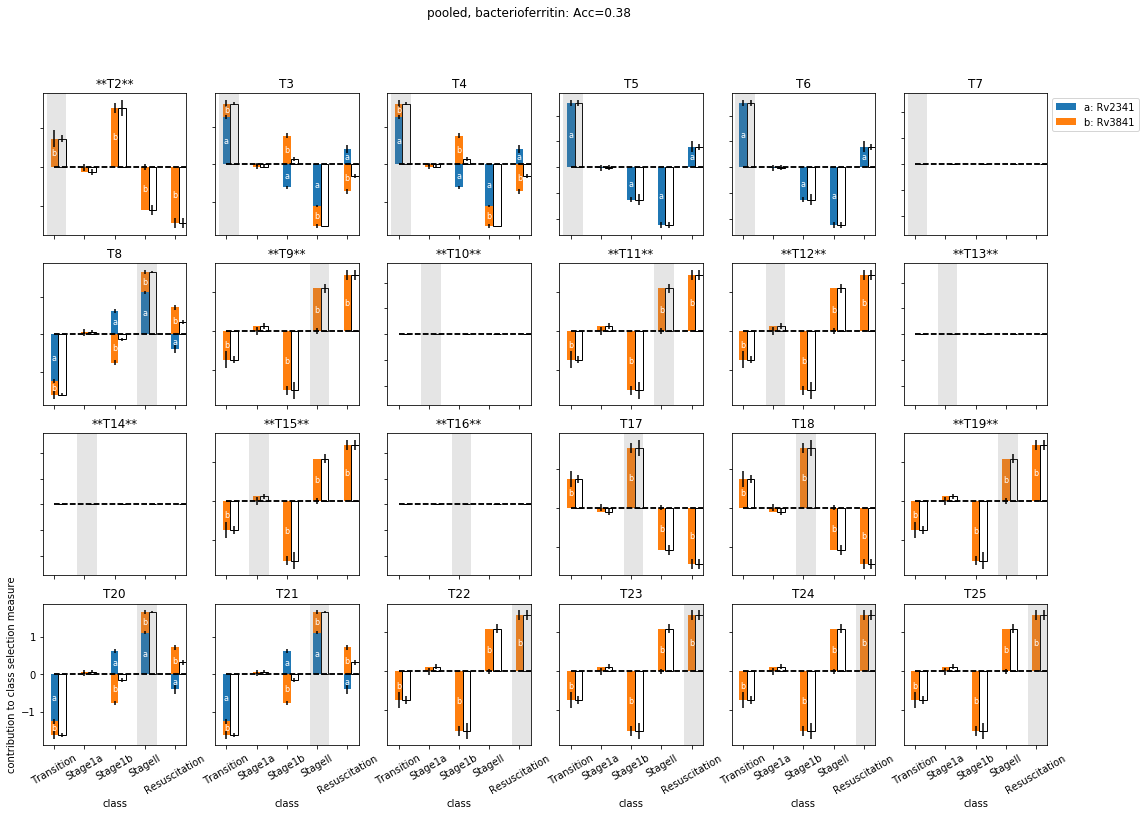

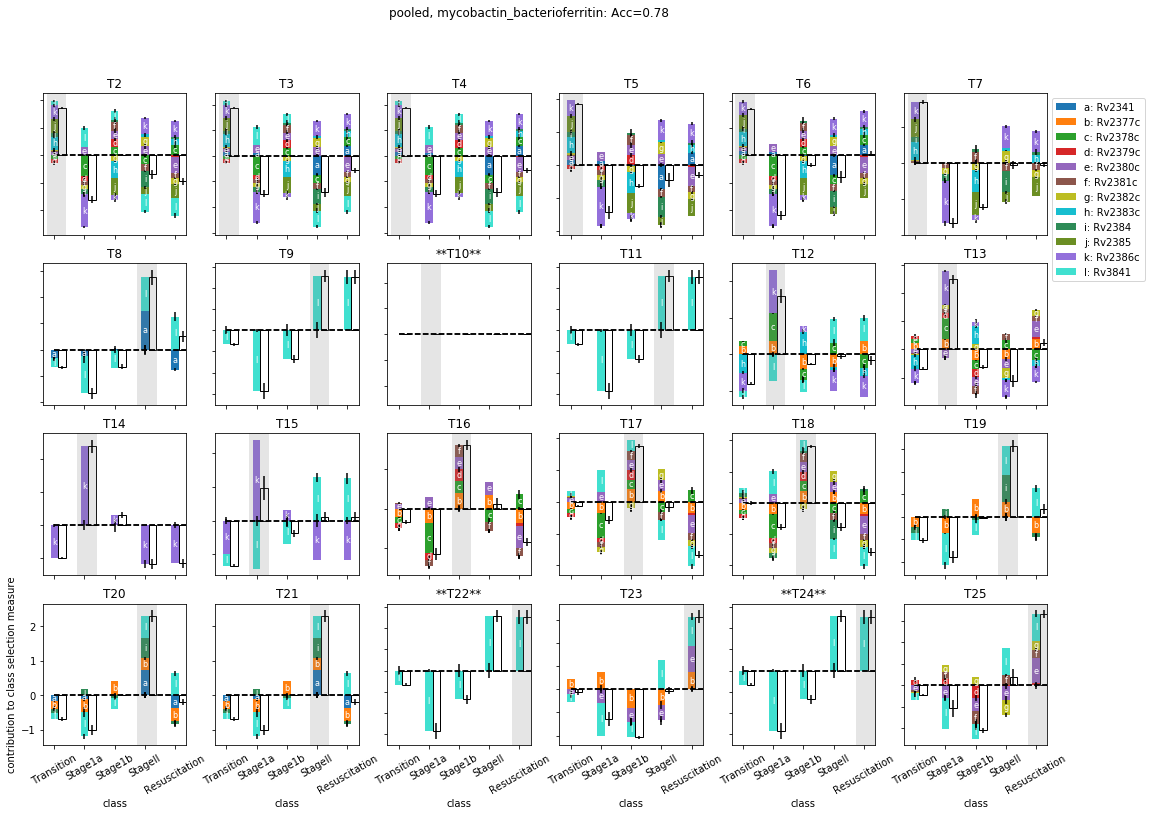

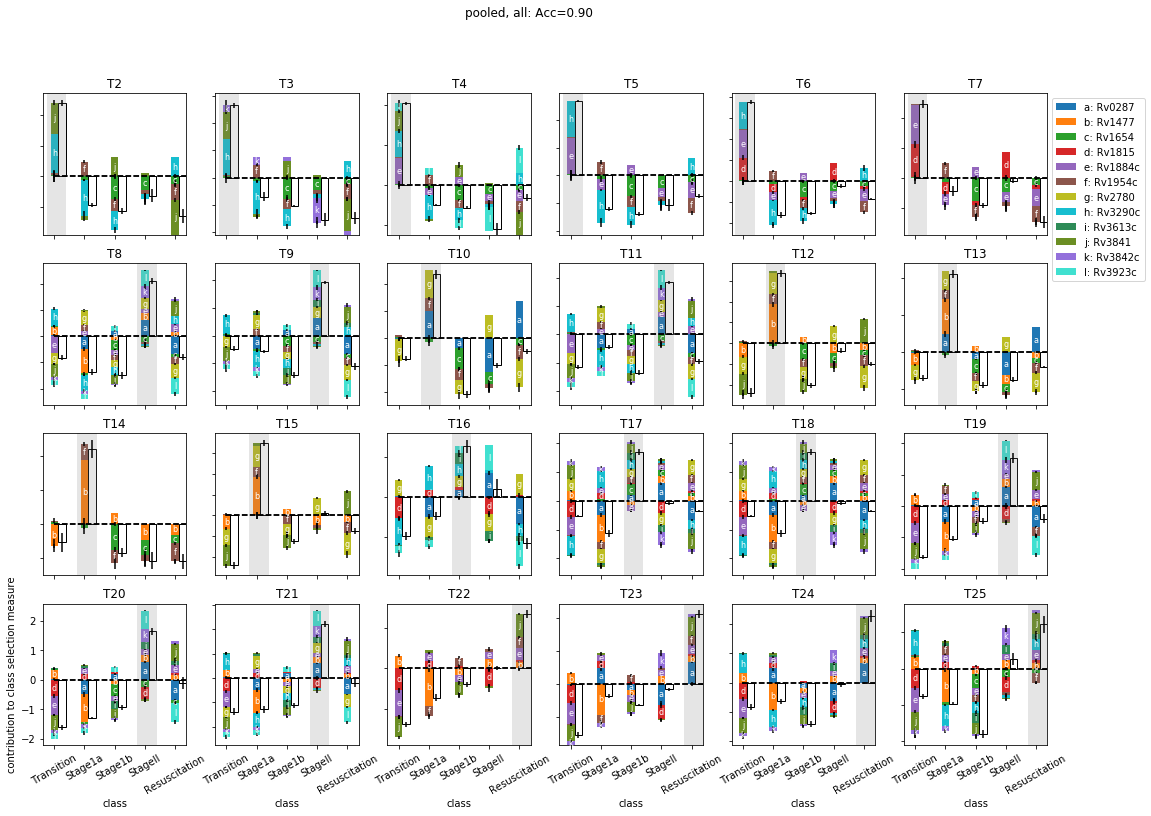

In [8]:
if FULL_RUN:
    for key, clf in CLASSIFIER_DCT.items():
        suptitle = "%s: Acc=%1.2f" % (", ".join(key), np.mean(CLASSIFIER_DCT[key].scores))
        clf.evaluateClassifierOnInstances(ser_y=DATA_DCT[key[0]].ser_y, nrow=4, ncol=6, 
                                      suptitle=suptitle)

# Classification Validations on Training Samples
Classify T2-T25 and see if result is same as original class. Use 5-fold cross validation, where there is a holdout for each class and the selection is random.


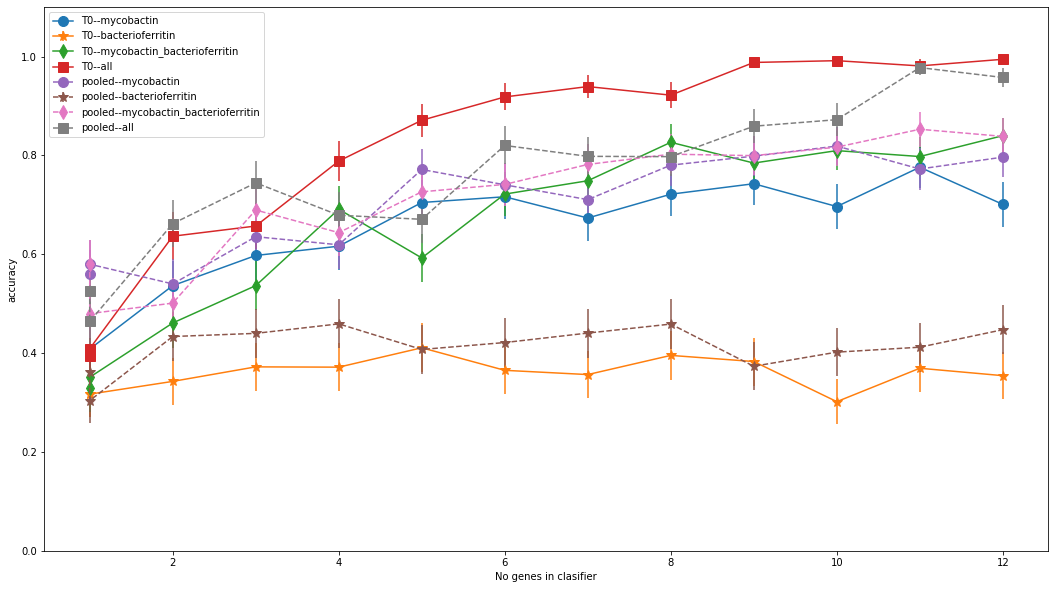

In [9]:
# Plot accuracy for the number of genes for each classifier
df_accuracy = DF_ACCURACY
markers = ["o", "*", "d", "s"]
marker_dct = {g: m for g, m in zip(GENE_GROUPS, markers)}
line_dct = {r: l for r, l in zip(DATA_DCT.keys(), ["-", "--"])}
legends = []
_, ax = plt.subplots(1, figsize=(18, 10))
# Plot
for (ref, group), clf in CLASSIFIER_DCT.items():
    legends.append("--".join([ref, group]))
    marker = marker_dct[group]
    line_style = line_dct[ref]
    sel1 = df_accuracy[make_classification_data.COL_REF] == ref
    sel2 = df_accuracy[make_classification_data.COL_GENE_GROUP] == group
    sel = [s1 and s2 for s1, s2 in zip(sel1, sel2)]
    df = df_accuracy[sel]
    xvals = df[make_classification_data.COL_NUM_FEATURE].values
    yvals = df[make_classification_data.COL_MEAN_ACCURACY].values
    ystds = df[make_classification_data.COL_STD_ACCURACY].values
    #yvals = np.array([v for v in df_accuracy[.values()])
    #ystds = np.sqrt(yvals*(1-yvals)/num_clf)
    ax.errorbar(xvals, yvals, yerr=ystds, marker=marker, linestyle=line_style, markersize=10)
    ax.set_ylim([0, 1.1])
    _ = ax.set_xlabel("No genes in clasifier")
    _ = ax.set_ylabel("accuracy")
    ax.legend(legends)

**TODO**: 
1. Verify values plotted for coefficients.
1. Fix the legend
1. Find the genes associated with each point and see the genes necessary to reach plateau.

# Classifier Coefficients

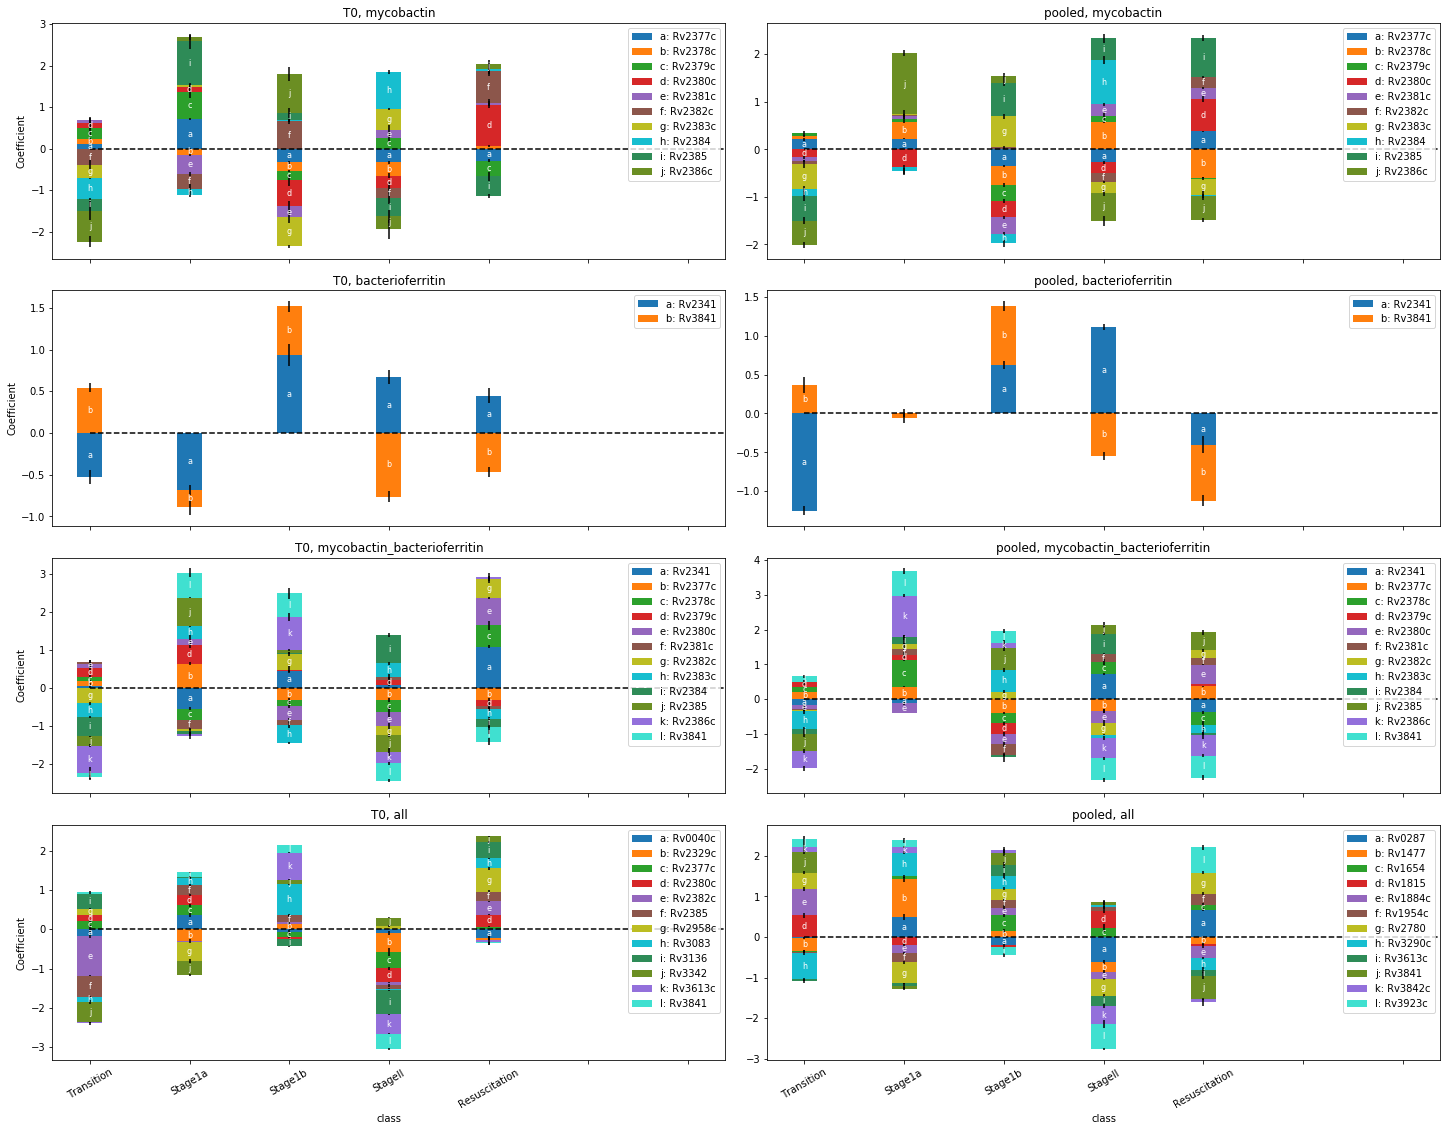

In [10]:
# Plot the classifier coefficients for each gene
nrow = 4
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 15))
fig.tight_layout()
keys = []
irow = 0
for genes in ["mycobactin", "bacterioferritin", "mycobactin_bacterioferritin", "all"]:
    icol = 0
    for ref in ["T0", "pooled"]:
        key = (ref, genes)
        clf = CLASSIFIER_DCT[key]
        title = ", ".join(key)
        if icol == 1:
            is_legend = True
        else:
            is_legend = False
        ax = axes[irow, icol]
        clf.plotSVMCoefficients(title=title, ax=ax, class_names=STAGE_NAMES, is_plot=False, is_legend_on_plot=True)
        if irow < nrow - 1:
            ax.set_xticklabels([])
            ax.set_xlabel("")
        if icol > 0:
            ax.set_ylabel("")
        icol += 1
    irow += 1
plt.show()

**TO DO**: Note difference in roles of genes for each state based on pooled vs. TO.

The above chart displays the values of the SVM coefficients for each of the genes for the classifier used to identify each state. The vertical lines are error bars ($\pm$ 1 standard deviation) for the value of the coefficient over 100 classifiers constructed using 1 holdout per state.

The coefficients are used to identify the stage that best matches a gene expression vector. Given
an expression vector $\mathbf{x} = (x_1, \cdots, x_N)$, where $x_n \in [-1, 1 ]$ is the expression level of gene $x_n$ and
$c_{m,n}$ is the coefficient for the classifier for stage $m$ and gene $n$:
1. $d_m = \sum_n c_{m,n} x_n$
1. Choose stage $m^{\star}$ such that $m^{\star} = arg max_m \{ d_m \}$

Several observations are of interest:
1. The coefficients for Transition are mostly negative, which means that this stage is about *under-expression*.
In particular, this stage is characterized by an under-expression of the genes Rv2383c, Rv2382c, Rv2386c, and Rv2385.
1. We see that Stage1a is characterized by large positive values of the coefficients for Rv2385, Rv3841, and Rv2384.
Although this makes sense for Rv2385, it is counter intuitive for
Rv2384 and Rv3841.
The rationale here is more complicated.
Rv2384 is not differentially expressed in Stage 1a; however, it is under-expressed in Transition.
So, a positive coefficient for Rv2384 for Stage 1a allows for differentiation from Transition.
A similar tactic seems to be in play for Rv3841 to distinguish Stage1a from Stage II and Resuscitation.
However, this is complicated by the fact that Transition over-expresses Rv3841.
The classifier compensates for this by having a large coefficient for Rv2384.

1. The other stages are characterized by a mixture of over- and under-expression.

# Summary Comments

1. Choice of control
   1. Criteria for choice
1. Evaluating the quality of classification for test samples
   1. Consistency between replications
   1. Consistency in stage progression of replication
1. Detailed summaries for data sets
1. Selection of genes based on classification accuracy selects some, but not all of the mycobactin genes. 
   1. Which are not selected?
   1. What additional genes are selected?
   1. What are the signs and magnitudes of the mycobactin genes in the "all" case?
1. Using pooled data results in very different gene selections